In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib
matplotlib.rcParams['font.family']='Malgun Gothic'

In [2]:
df = pd.read_csv('../Data/hysteresis/attachments/hys_kjh.csv')

In [3]:
df.head(3)

,Unnamed: 0,e,f
0,1,0.000000,0.000000
1,2,0.000000,0.015758
2,3,0.000234,0.030466


<Axes: >

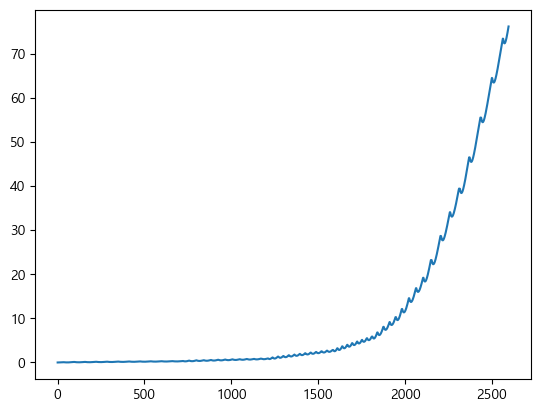

In [4]:
df.e.plot()

<Axes: >

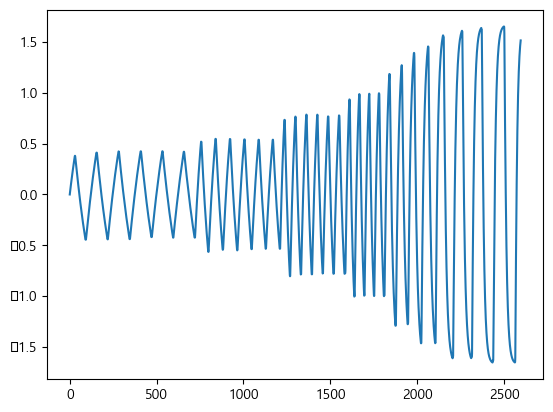

In [5]:
df.f.plot()

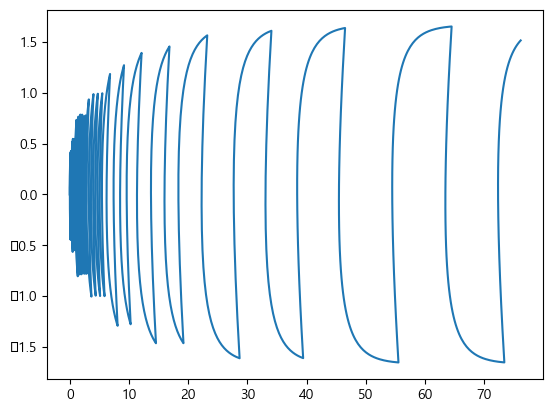

In [6]:
plt.plot(df.iloc[:,1], df.iloc[:,2])

In [7]:
df = df.iloc[:,1:]

<Axes: >

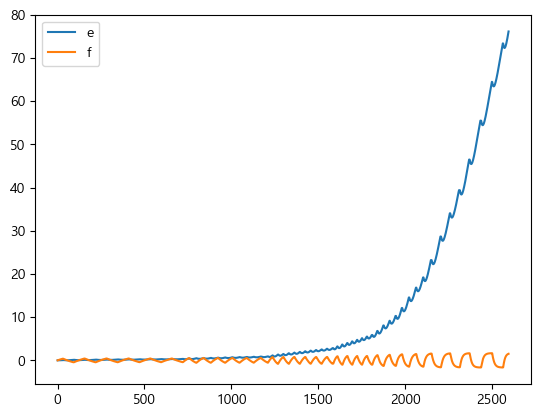

In [8]:
df.plot()

In [9]:
#hysteresis curve equation
def hys_curve(x, a, b, c, d, e, f):
    return a*x**5 + b*x**4 + c*x**3 + d*x**2 + e*x + f


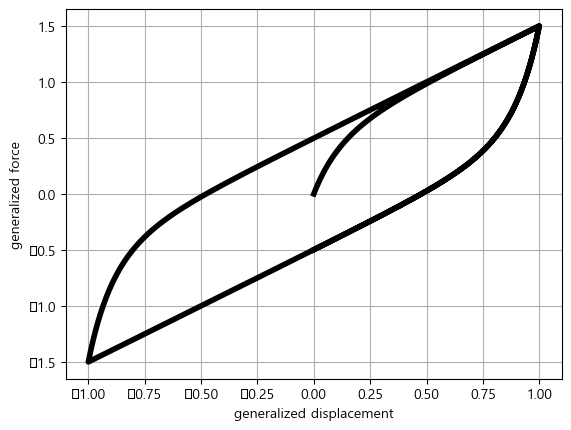

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# APPLIED DISPLACEMENT TIME HISTORY
dt = 0.001
t = np.arange(0, 1.5 + dt, dt)
a0 = 1
fr = 1
u = a0 * np.sin(2 * np.pi * fr * t[:len(t)])
v = 2 * np.pi * fr * a0 * np.cos(2 * np.pi * fr * t[:len(t)])
n = len(u)

# 1. INITIAL SETTINGS
# 1.1 Set the five model parameters
ka = 10.0
kb = 1.0
alfa = 10.0
beta1 = 0.0
beta2 = 0.0

# 1.2 Compute the internal model parameters
u0 = 0.5 * (((ka - kb) / 1e-20) ** (1 / alfa) - 1)
f0 = ((ka - kb) / 2) * (((1 + 2 * u0) ** (1 - alfa) - 1) / (1 - alfa))

# 1.3 Initialize the generalized force vector
f = np.zeros(n)

# 2. CALCULATIONS AT EACH TIME STEP
for i in range(1, n):
    # 2.1 Update the history variable
    uj = u[i - 1] + np.sign(v[i]) * (1 + 2 * u0) - np.sign(v[i]) * (((np.sign(v[i]) * (1 - alfa)) / (ka - kb)) * (f[i - 1] - beta1 * u[i - 1] ** 3 - beta2 * u[i - 1] ** 5 - kb * u[i - 1] - np.sign(v[i]) * f0 + (ka - kb) * (((1 + 2 * u0) ** (1 - alfa)) / (np.sign(v[i]) * (1 - alfa))))) ** (1 / (1 - alfa))

    # 2.2 Evaluate the generalized force at time t
    if (np.sign(v[i]) * uj) - 2 * u0 < np.sign(v[i]) * u[i] or np.sign(v[i]) * u[i] < np.sign(v[i]) * uj:
        f[i] = beta1 * u[i] ** 3 + beta2 * u[i] ** 5 + kb * u[i] + (ka - kb) * ((((1 + 2 * u0 + np.sign(v[i]) * (u[i] - uj)) ** (1 - alfa)) / (np.sign(v[i]) * (1 - alfa))) - (((1 + 2 * u0) ** (1 - alfa)) / (np.sign(v[i]) * (1 - alfa)))) + np.sign(v[i]) * f0
    else:
        f[i] = beta1 * u[i] ** 3 + beta2 * u[i] ** 5 + kb * u[i] + np.sign(v[i]) * f0

# PLOT
plt.figure()
plt.plot(u, f, 'k', linewidth=4)
plt.xlabel('generalized displacement')
plt.ylabel('generalized force')
plt.grid()
plt.show()


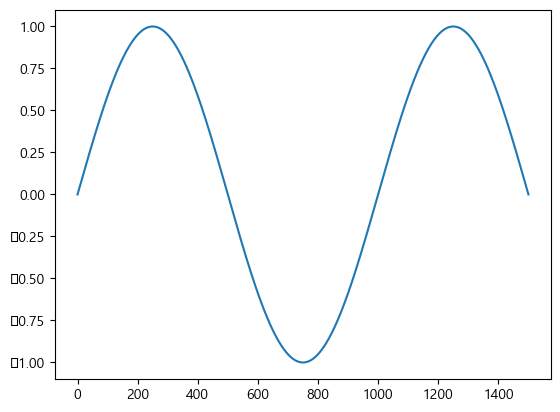

In [11]:
plt.plot(u)

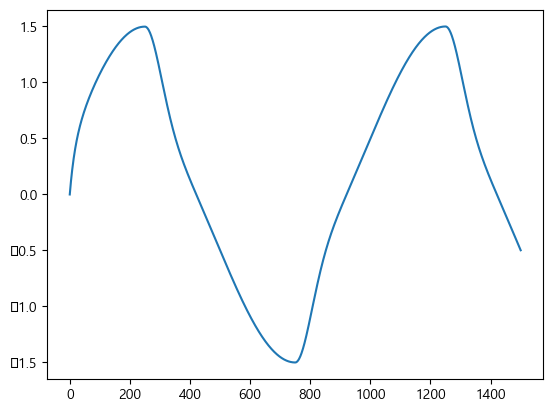

In [12]:
plt.plot(f)

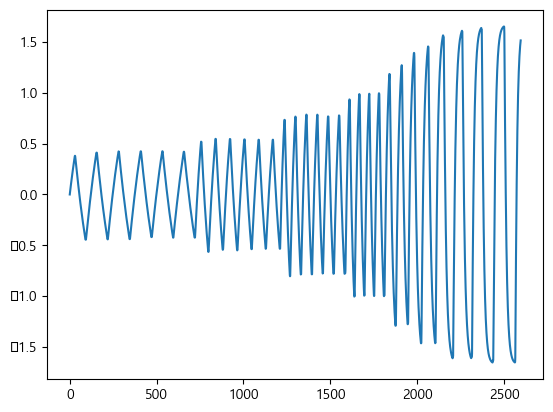

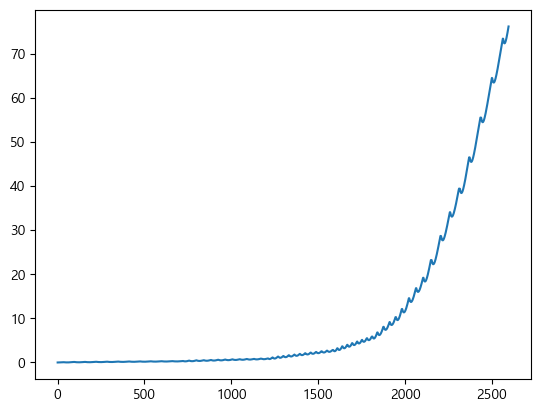

In [13]:
plt.plot(df.iloc[:,1])
plt.show()
plt.plot(df.iloc[:,0])
plt.show()

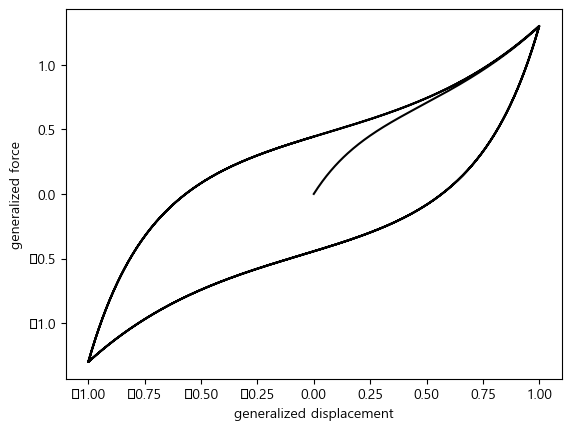

In [14]:
# APPLIED DISPLACEMENT TIME HISTORY
dt = 0.001
t = np.arange(0, 3 + dt, dt)
a0 = 1
fr = 1
u = a0 * np.sin(2 * np.pi * fr * t[:len(t)])
v = 2 * np.pi * fr * a0 * np.cos(2 * np.pi * fr * t[:len(t)])
n = len(u)

# INITIAL SETTINGS
# Set the four model parameters
ka = 5.0
kb = 0.5
alfa = 5.0
beta = 1.0
# Compute the internal model parameters
u0 = -(1 / (2 * alfa)) * np.log(10 ** -20 / (ka - kb))
f0 = ((ka - kb) / (2 * alfa)) * (1 - np.exp(-2 * alfa * u0))
# Initialize the generalized force vector
f = np.zeros(n)

# CALCULATIONS AT EACH TIME STEP
for i in range(1, n):
    # Update the history variable
    uj = u[i-1] + 2*u0*np.sign(v[i]) + np.sign(v[i])*(1/alfa)*np.log(np.abs(np.sign(v[i])*(alfa/(ka-kb))*(-2*beta*u[i-1]+np.exp(beta*u[i-1])-np.exp(-beta*u[i-1])+kb*u[i-1]+np.sign(v[i])*((ka-kb)/alfa)*np.exp(-2*alfa*u0)+np.sign(v[i])*f0-f[i-1])))
    # Evaluate the generalized force at time t
    if (np.sign(v[i])*uj-2*u0 < np.sign(v[i])*u[i]) or (np.sign(v[i])*u[i] < np.sign(v[i])*uj):
        f[i] = -2*beta*u[i] + np.exp(beta*u[i]) - np.exp(-beta*u[i]) + kb*u[i] - np.sign(v[i])*((ka-kb)/alfa)*(np.exp(-alfa*(np.sign(v[i])*(u[i]-uj)+2*u0))-np.exp(-2*alfa*u0)) + np.sign(v[i])*f0
    else:
        f[i] = -2*beta*u[i] + np.exp(beta*u[i]) - np.exp(-beta*u[i]) + kb*u[i] + np.sign(v[i])*f0

# PLOT
plt.figure()
plt.plot(u, f, 'k')
plt.xlabel('generalized displacement')
plt.ylabel('generalized force')
plt.show()


In [15]:
from sklearn.preprocessing import StandardScaler

In [16]:
sc = StandardScaler()

In [17]:
import keras
from keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM
from keras import optimizers

In [18]:
total = pd.DataFrame()

In [19]:
total['u'] = u
total['time'] = t
total['f'] = f


In [20]:
total

,u,time,f
0,0.000000e+00,0.000,0.000000
1,6.283144e-03,0.001,0.017059
2,1.256604e-02,0.002,0.033687
3,1.884844e-02,0.003,0.049898
4,2.513010e-02,0.004,0.065705
...,...,...,...
2996,-2.513010e-02,2.996,0.430554
2997,-1.884844e-02,2.997,0.433910
2998,-1.256604e-02,2.998,0.437259
2999,-6.283144e-03,2.999,0.440601


In [21]:
x = total.iloc[:,0:2]
y = total.f

In [22]:
x_tf = tf.convert_to_tensor(x.values)
y_tf = tf.convert_to_tensor(y)

In [23]:
x_tr = x_tf[:2000]
x_te = x_tf[2000:]
y_tr = y_tf[:2000]
y_te = y_tf[2000:]

----
## LSTM

In [24]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(64, input_shape=(2, 1), return_sequences=True))
model.add(tf.keras.layers.LSTM(64))
model.add(tf.keras.layers.Dense(1))

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 2, 64)             16896     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________


In [26]:
adam = optimizers.Adam(lr=0.01)

In [27]:
model.compile(loss = 'mse', optimizer = adam, metrics = 'mse')

In [28]:
history = model.fit(x_tr, y_tr, epochs = 500)

Epoch 1/500
63/63 [==============================] - 3s 2ms/step - loss: 0.1892 - mse: 0.1892
Epoch 2/500
63/63 [==============================] - 0s 2ms/step - loss: 0.1301 - mse: 0.1301
Epoch 3/500
63/63 [==============================] - 0s 2ms/step - loss: 0.1173 - mse: 0.1173
Epoch 4/500
63/63 [==============================] - 0s 2ms/step - loss: 0.1067 - mse: 0.1067
Epoch 5/500
63/63 [==============================] - 0s 2ms/step - loss: 0.1055 - mse: 0.1055
Epoch 6/500
63/63 [==============================] - 0s 2ms/step - loss: 0.1049 - mse: 0.1049
Epoch 7/500
63/63 [==============================] - 0s 2ms/step - loss: 0.1079 - mse: 0.1079
Epoch 8/500
63/63 [==============================] - 0s 2ms/step - loss: 0.1011 - mse: 0.1011
Epoch 9/500
63/63 [==============================] - 0s 2ms/step - loss: 0.1009 - mse: 0.1009
Epoch 10/500
63/63 [==============================] - 0s 2ms/step - loss: 0.0998 - mse: 0.0998
Epoch 11/500
63/63 [==============================] - 0s 2m

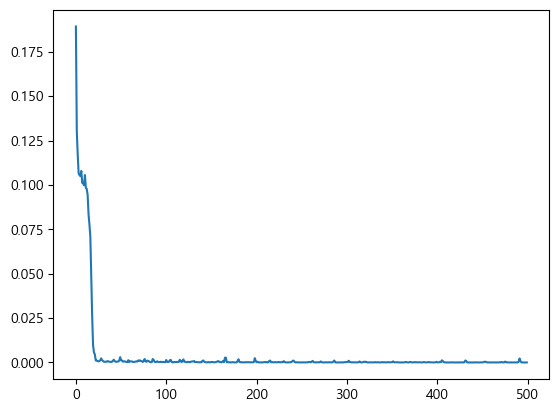

In [29]:
plt.plot(history.history['loss'])

In [30]:
pred = model.predict(x_te)

32/32 [==============================] - 1s 807us/step


In [31]:
pred = pred.reshape(-1,1)

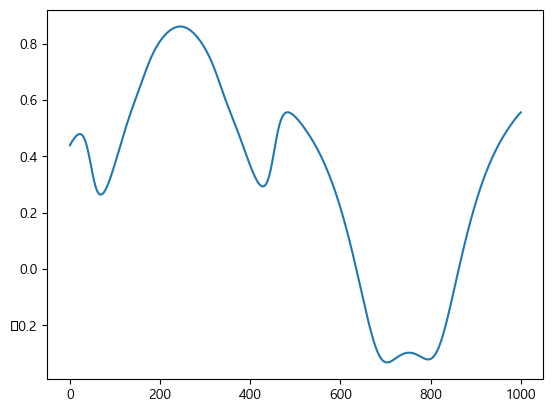

In [32]:
plt.plot(pred)

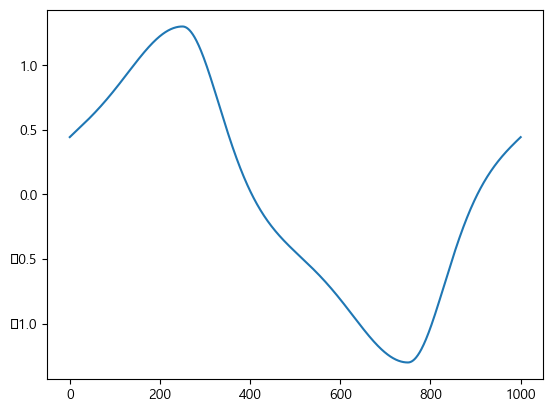

In [33]:
plt.plot(y_te)

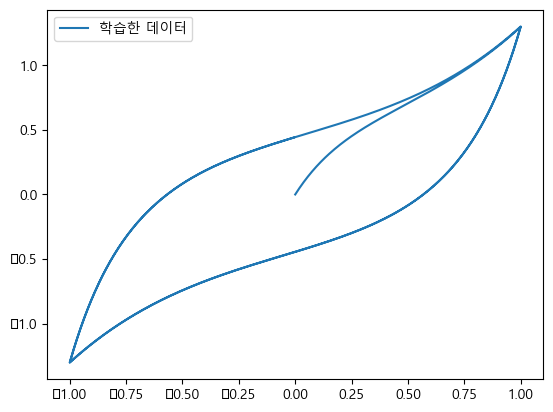

In [34]:
plt.plot(x.iloc[:2000,0], y.iloc[:2000], label = '학습한 데이터')
plt.legend()
plt.show()

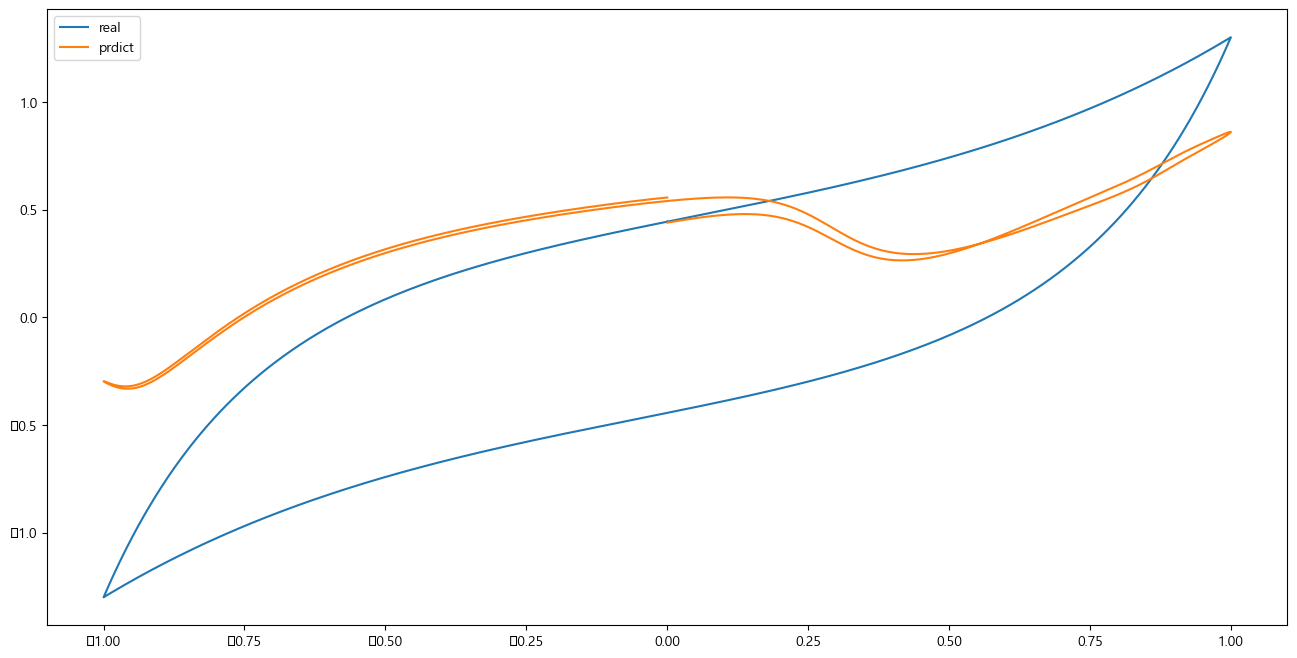

In [35]:
plt.figure(figsize=(16,8))
plt.plot(x.iloc[2000:,0], y.iloc[2000:], label = 'real')
plt.plot(x.iloc[2000:,0], pred, label = 'prdict')
plt.legend()
plt.show()

----
## DNN

In [36]:
model_2 = Sequential()
model_2.add(tf.keras.layers.Dense(32, input_shape=(2,)))
model_2.add(tf.keras.layers.Dense(64, activation='sigmoid'))
model_2.add(tf.keras.layers.Dense(128, activation='sigmoid'))
model_2.add(tf.keras.layers.Dense(64, activation='sigmoid'))
model_2.add(tf.keras.layers.Dense(1))

model_2.compile(loss = 'mse', optimizer = adam)

In [37]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 32)                96        
                                                                 
 dense_2 (Dense)             (None, 64)                2112      
                                                                 
 dense_3 (Dense)             (None, 128)               8320      
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 18,849
Trainable params: 18,849
Non-trainable params: 0
_________________________________________________________________


In [38]:
dnn = model_2.fit(x_tr, y_tr, epochs=500)

Epoch 1/500
63/63 [==============================] - 0s 629us/step - loss: 1.3118
Epoch 2/500
63/63 [==============================] - 0s 629us/step - loss: 0.6936
Epoch 3/500
63/63 [==============================] - 0s 613us/step - loss: 0.6832
Epoch 4/500
63/63 [==============================] - 0s 629us/step - loss: 0.6911
Epoch 5/500
63/63 [==============================] - 0s 613us/step - loss: 0.6924
Epoch 6/500
63/63 [==============================] - 0s 597us/step - loss: 0.6895
Epoch 7/500
63/63 [==============================] - 0s 613us/step - loss: 0.7101
Epoch 8/500
63/63 [==============================] - 0s 613us/step - loss: 0.6946
Epoch 9/500
63/63 [==============================] - 0s 613us/step - loss: 0.6893
Epoch 10/500
63/63 [==============================] - 0s 613us/step - loss: 0.6912
Epoch 11/500
63/63 [==============================] - 0s 613us/step - loss: 0.6936
Epoch 12/500
63/63 [==============================] - 0s 629us/step - loss: 0.6890
Epoch 13/500


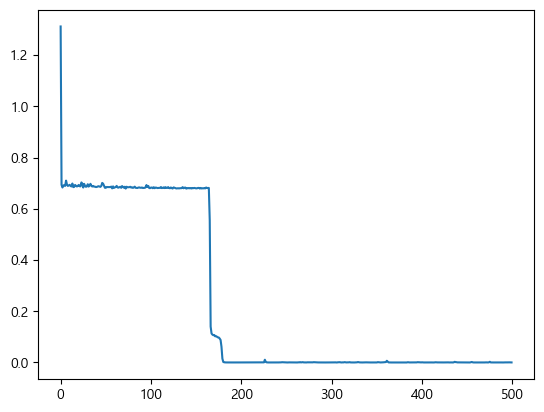

In [39]:
plt.plot(dnn.history['loss'])

In [40]:
pred_2 = model_2.predict(x_te)

32/32 [==============================] - 0s 484us/step


In [41]:
pred_2 = pred_2.reshape(-1,1)

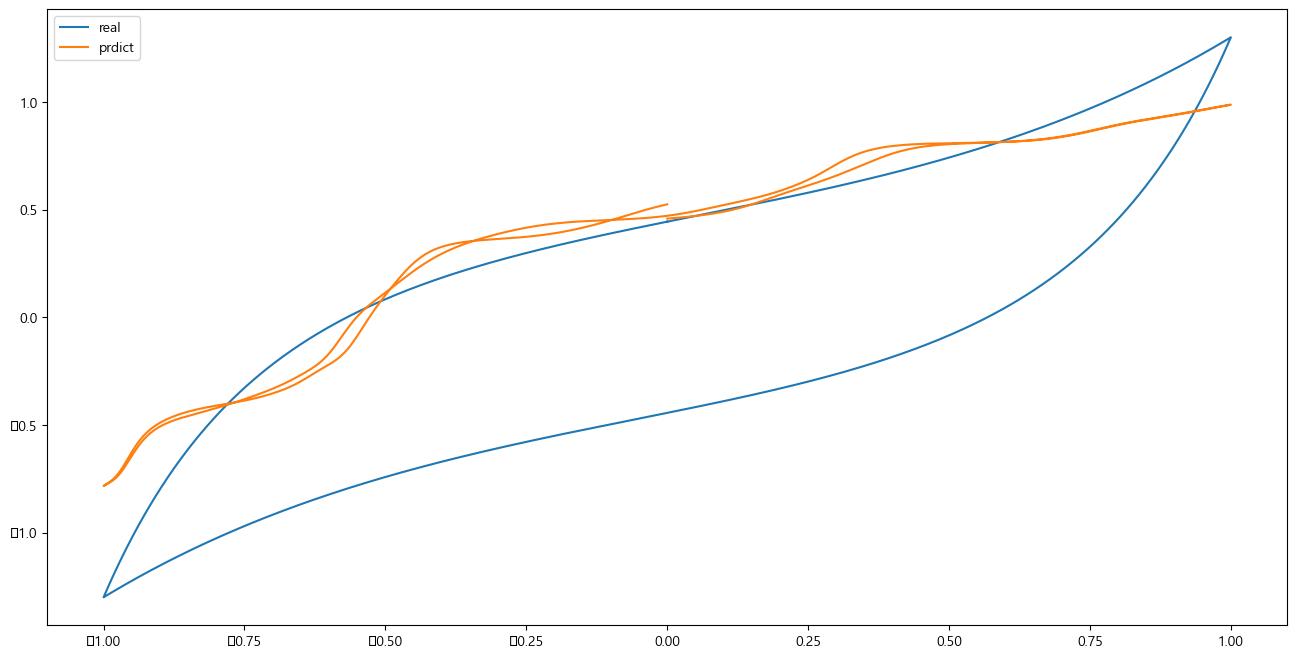

In [42]:
plt.figure(figsize=(16,8))
plt.plot(x.iloc[2000:,0], y.iloc[2000:], label = 'real')
plt.plot(x.iloc[2000:,0], pred_2, label = 'prdict')
plt.legend()
plt.show()

---
## PINN

In [43]:
x0, y0 = 0, 0
w = 0.5
mu = 0.1

In [44]:
from scipy.integrate import odeint
from math import *

In [46]:
def xt(x, t):
    return -2*beta*x[1] + np.exp(beta*x[1]) - np.exp(-beta*x[1]) + kb*x[1] - np.sign(v[i])*((ka-kb)/alfa)*(np.exp(-alfa*(np.sign(v[i])*(x[1]-uj)+2*u0))-np.exp(-2*alfa*u0)) + np.sign(v[i])*f0

In [110]:
def xt_tf(x, t):
    return -2 * beta * x[1] + tf.exp(beta * x[1]) - tf.exp(-beta * x[1]) + kb * x[1] - tf.sign(v[i]) * ((ka - kb) / alfa) * (tf.exp(-alfa * (tf.sign(v[i]) * (x[1] - uj) + 2 * u0)) - tf.exp(-2 * alfa * u0)) + tf.sign(v[i]) * f0


In [96]:
x_tr

<tf.Tensor: shape=(2000, 2), dtype=float64, numpy=
array([[ 0.00000000e+00,  0.00000000e+00],
       [ 6.28314397e-03,  1.00000000e-03],
       [ 1.25660399e-02,  2.00000000e-03],
       ...,
       [-1.88484397e-02,  1.99700000e+00],
       [-1.25660399e-02,  1.99800000e+00],
       [-6.28314397e-03,  1.99900000e+00]])>

In [108]:
xt(x_tr[1], 0)

<tf.Tensor: shape=(), dtype=float64, numpy=0.44446636704645487>

In [49]:
class PINN(tf.keras.Model):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.hidden_layer_1 = tf.keras.layers.Dense(units=128, activation=tf.nn.tanh)
        self.hidden_layer_2 = tf.keras.layers.Dense(units=128, activation=tf.nn.tanh)
        self.output_layer = tf.keras.layers.Dense(units=output_dim)

    def call(self, inputs):
        x = self.hidden_layer_1(inputs)
        x = self.hidden_layer_2(x)
        output = self.output_layer(x)
        return output

In [71]:
model = PINN(2, 1)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_fn = tf.keras.losses.MeanSquaredError()

ephoch = 500

In [64]:
from tqdm import tqdm

In [72]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices((x_tr, y_tr))
dataset = dataset.batch(batch_size)

with tf.device('/GPU:0'):
    model = PINN(2, 1)

x_tr = tf.constant(x_tr, dtype=tf.float64)
y_tr = tf.constant(y_tr, dtype=tf.float64)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_fn = tf.keras.losses.MeanSquaredError()

for epoch in tqdm(range(ephoch)):
    for x_batch, y_batch in dataset:
        with tf.GradientTape() as tape:
            y_pred = model(x_batch)
            loss_value = loss_fn(y_batch, y_pred)
        
        gradients = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))


100%|██████████| 500/500 [05:55<00:00,  1.41it/s]


In [ ]:
# APPLIED DISPLACEMENT TIME HISTORY
dt = 0.001
t = np.arange(0, 3 + dt, dt)
a0 = 1
fr = 1
u = a0 * np.sin(2 * np.pi * fr * t[:len(t)])
v = 2 * np.pi * fr * a0 * np.cos(2 * np.pi * fr * t[:len(t)])
n = len(u)

# INITIAL SETTINGS
# Set the four model parameters
ka = 5.0
kb = 0.5
alfa = 5.0
beta = 1.0
# Compute the internal model parameters
u0 = -(1 / (2 * alfa)) * np.log(10 ** -20 / (ka - kb))
f0 = ((ka - kb) / (2 * alfa)) * (1 - np.exp(-2 * alfa * u0))
# Initialize the generalized force vector
f = np.zeros(n)


In [90]:
def physics_loss(x, y_true, model):
    # Bouc-Wen 모델의 매개변수
    omega_n = 1 
    xi =  x 
    alpha =   5 
    beta_s =   1 
    n = 1

    y_pred = model(x)

    # Bouc-Wen 모델 미분 방정식 계산
    # 아래는 단순히 예를 보여주는 것으로, 실제로는 미분 방정식을 구현하고 시간 동안의 상태를 추적해야 합니다.
    bouc_wen_pred = xt(x, 0)

    # 물리학적 손실을 계산합니다.
    physics_loss = tf.keras.losses.MSE(bouc_wen_pred,y_pred)

    # 데이터 기반 손실을 계산합니다.
    data_loss = tf.keras.losses.MSE(y_true, y_pred)

    # 두 손실을 결합합니다. 이 경우에는 두 손실을 동일하게 취급하지만, 필요에 따라 가중치를 조정할 수 있습니다.
    return physics_loss + data_loss


In [91]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices((x_tr, y_tr))
dataset = dataset.batch(batch_size)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_fn = physics_loss

for epoch in tqdm(range(ephoch)):
    for x_batch, y_batch in dataset:
        with tf.GradientTape() as tape:
            loss_value = tf.reduce_mean(loss_fn(x_batch, y_batch, model))

        gradients = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  0%|          | 0/500 [00:00<?, ?it/s]


TypeError: Argument `target` should be a list or nested structure of Tensors, Variables or CompositeTensors to be differentiated, but received None.